In [ ]:
dftrain.drop(['id'],axis=1,inplace=True)
dftrain

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

# Define the preprocess function
def preprocess(text):
    # Remove URLs
    pattern = r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"
    text = re.sub(pattern, "", text)

    # Remove emoji
    pattern = "[" + u"\U0001F600-\U0001F64F" \
                 + u"\U0001F300-\U0001F5FF" \
                 + u"\U0001F680-\U0001F6FF" \
                 + u"\U0001F1E0-\U0001F1FF" \
                 + u"\U00002702-\U000027B0" \
                 + u"\U000024C2-\U0001F251" \
                 + "]+"
    text = re.sub(pattern, "", text, flags=re.UNICODE)

    # Remove IP addresses
    pattern = r"\b(?:\d{1,3}\.){3}\d{1,3}\b"
    text = re.sub(pattern, "", text)

    # Remove special characters
    pattern = r"[^\w\s]"
    text = re.sub(pattern, "", text)

    # Remove HTML tags
    pattern = r"<[^>]+>"
    text = re.sub(pattern, "", text)

    # Remove CSS syntax and inline styles
    pattern = r"(?i)<style([\s\S]*?)<\/style>|<script([\s\S]*?)<\/script>"
    text = re.sub(pattern, "", text)

    return text

#To speed up the data preprocessing and cleaning as the dataset is somewhat large
from multiprocessing import Pool

def preprocess_parallel(text):
    return preprocess(text)

with Pool() as pool:
    texts = pool.map(preprocess_parallel, dftrain['comment_text'])

print(len(texts),len(dftrain))


159571 159571


In [ ]:
# Extract input (comment_text) and output (labels) from the DataFrame
input_texts = texts
output_labels = dftrain.iloc[:, 1:].values  # Assumes label columns are from index 1 to the end

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    input_texts, output_labels, test_size=0.2, random_state=42)

# Tokenize the input texts
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences to a fixed length
max_length = 6  # Adjust the maximum length as per your requirement
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

# Convert the output labels to categorical format
num_classes = output_labels.shape[1]  # Get the number of label columns
train_labels_categorical =train_labels
test_labels_categorical = test_labels

In [ ]:
train_labels_categorical.shape,train_sequences.shape,test_sequences.shape

((127656, 6), (127656, 6), (31915, 6))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D

# Define the model architecture
embedding_dim = 100  # Adjust the dimensionality of the word embeddings as per your requirement

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(128, activation='relu'))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 6, 100)            20469200  
                                                                 
 bidirectional_8 (Bidirectio  (None, 6, 256)           234496    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 6, 128)            32896     
                                                                 
 lstm_12 (LSTM)              (None, 6, 64)             49408     
                                                                 
 dense_14 (Dense)            (None, 6, 64)             4160      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                     

In [ ]:
# Train the model
batch_size = 32  # Adjust the batch size as per your requirement
epochs = 10  # Adjust the number of epochs as per your requirement

In [ ]:
history=model.fit(train_sequences, train_labels_categorical, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels_categorical))

Epoch 1/10
3990/3990 [==============================] - 77s 17ms/step - loss: 0.0894 - accuracy: 0.9803 - val_loss: 0.0821 - val_accuracy: 0.9941
Epoch 2/10
3990/3990 [==============================] - 62s 15ms/step - loss: 0.0688 - accuracy: 0.9898 - val_loss: 0.0828 - val_accuracy: 0.9941
Epoch 3/10
3990/3990 [==============================] - 62s 15ms/step - loss: 0.0599 - accuracy: 0.9838 - val_loss: 0.0878 - val_accuracy: 0.9941
Epoch 4/10
3990/3990 [==============================] - 61s 15ms/step - loss: 0.0531 - accuracy: 0.9884 - val_loss: 0.0941 - val_accuracy: 0.9941
Epoch 5/10
3990/3990 [==============================] - 61s 15ms/step - loss: 0.0472 - accuracy: 0.9910 - val_loss: 0.1001 - val_accuracy: 0.9926
Epoch 6/10
3990/3990 [==============================] - 61s 15ms/step - loss: 0.0416 - accuracy: 0.9714 - val_loss: 0.1081 - val_accuracy: 0.9818
Epoch 7/10
3990/3990 [==============================] - 62s 15ms/step - loss: 0.0372 - accuracy: 0.9734 - val_loss: 0.1244 -

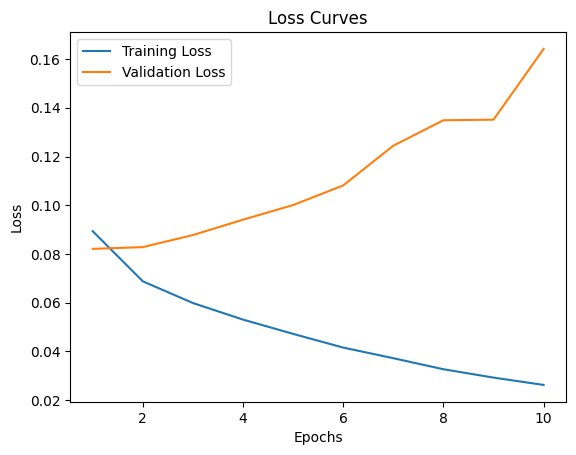

In [ ]:
import matplotlib.pyplot as plt

# Train the model and obtain the history object
#history = model.fit(train_sequences, train_labels_categorical, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels_categorical))

# Get the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


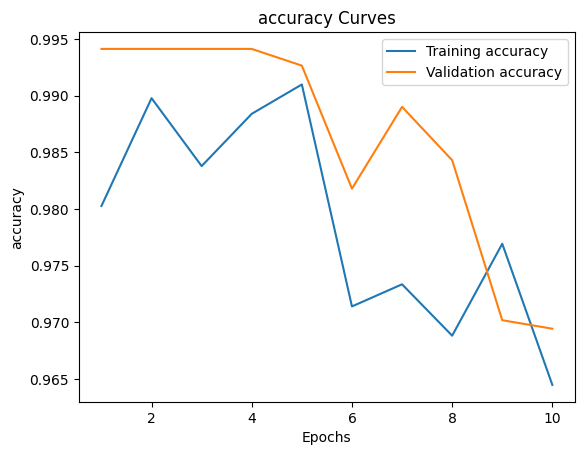

In [ ]:
import matplotlib.pyplot as plt

# Get the loss values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss curves
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy Curves')
plt.legend()
plt.show()


In [ ]:
model.evaluate(test_sequences,test_labels_categorical)

998/998 [==============================] - 6s 6ms/step - loss: 0.1642 - accuracy: 0.9695


[0.16415560245513916, 0.9694501161575317]

In [ ]:
import time
name="final_model.h5"#'model_'+str(time.ctime()).replace(" ","_")+'.h5'
model.save(name)

**Testing Model**

In [ ]:
df_test=pd.read_csv("/content/test/test.csv")
df_test_label=pd.read_csv("/content/testLabel/test_labels.csv")
# Perform the join based on the ID column
merged_df = pd.merge(df_test, df_test_label, on='id')

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)

merged_df.drop(['id'],axis=1,inplace=True)

merged_df.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
#data preprocessing
with Pool() as pool:
    texts = pool.map(preprocess_parallel, merged_df['comment_text'])
input_texts = texts
output_labels = merged_df.iloc[:, 1:].values  # Assumes label columns are from index 1 to the end

'''# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    input_texts, output_labels, test_size=0.2, random_state=42)'''

# Tokenize the input texts
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
train_sequences = tokenizer.texts_to_sequences(input_texts)
#test_sequences = tokenizer.texts_to_sequences(output_labels)

# Pad the sequences to a fixed length
max_length = 6  # Adjust the maximum length as per your requirement
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length)
#test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

# Convert the output labels to categorical format
num_classes = output_labels.shape[1]  # Get the number of label columns
train_labels_categorical =output_labels
#test_labels_categorical = test_labels


In [ ]:
evaluate=model.evaluate(train_sequences,train_labels_categorical)

4787/4787 [==============================] - 25s 5ms/step - loss: -5.6686 - accuracy: 0.9683


In [ ]:
Accuracy = evaluate[1]*100
print(f"Accuracy : {Accuracy:.2f}")

Accuracy : 96.83
